<a href="https://colab.research.google.com/github/gcosma/ConceptAnnotationPfD/blob/main/Final14Nov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single-Label Concept Annotation with Complete Preprocessing
## Fine-tuned PathologyBERT for Healthcare Safety Theme Classification

**Complete version with preprocessing for imbalanced small datasets**

This notebook:
1. Loads pre-split training and testing datasets
2. Handles class imbalance with data augmentation
3. Uses class weights for better minority class performance
4. Fine-tunes PathologyBERT for single-label classification
5. Evaluates model performance comprehensively
6. Provides inference functions for annotating new sentences

## 1. Install Required Libraries

In [1]:
!pip install -q transformers datasets torch scikit-learn pandas numpy accelerate imbalanced-learn

## 2. Import Libraries and Setup

In [2]:
import pandas as pd
import numpy as np
import torch
import re
import random
from typing import List, Dict
from collections import Counter

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✓ Libraries imported successfully")

Using device: cuda
✓ Libraries imported successfully


## 3. Upload Your Training and Testing CSV Files

In [4]:
from google.colab import files

print("Upload your TRAINING CSV file:")
uploaded_train = files.upload()
train_filename = list(uploaded_train.keys())[0]
print(f"✓ Training file uploaded: {train_filename}")

print("\nUpload your TESTING CSV file:")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
print(f"✓ Testing file uploaded: {test_filename}")

Upload your TRAINING CSV file:


Saving Training Iteration 2.csv to Training Iteration 2 (1).csv
✓ Training file uploaded: Training Iteration 2 (1).csv

Upload your TESTING CSV file:


Saving Testing Iteration 2.csv to Testing Iteration 2 (1).csv
✓ Testing file uploaded: Testing Iteration 2 (1).csv


## 4. Load and Clean Data

In [5]:
def load_csv_with_encoding(filename):
    """Try multiple encodings to load CSV file"""
    encodings = ['utf-8', 'latin-1', 'cp1252', 'iso-8859-1']

    for encoding in encodings:
        try:
            df = pd.read_csv(filename, encoding=encoding)
            print(f"✓ Loaded with {encoding} encoding")
            return df
        except UnicodeDecodeError:
            continue

    print("Using latin-1 encoding with error handling")
    return pd.read_csv(filename, encoding='latin-1', errors='replace')

def clean_text(text):
    """Clean text by replacing encoding artifacts"""
    if pd.isna(text):
        return ""

    text = str(text)

    # Replace common Windows-1252 encoding artifacts
    replacements = {
        '\x91': "'", '\x92': "'", '\x93': '"', '\x94': '"',
        '\x96': '-', '\x97': '-', '\x85': '...', '\x95': '*',
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Load and clean data
print("Loading training data...")
train_df = load_csv_with_encoding(train_filename)
train_df['Text'] = train_df['Text'].apply(clean_text)
train_df['Label'] = train_df['Label'].apply(clean_text)
train_df = train_df[(train_df['Text'] != '') & (train_df['Label'] != '')].reset_index(drop=True)

print("\nLoading testing data...")
test_df = load_csv_with_encoding(test_filename)
test_df['Text'] = test_df['Text'].apply(clean_text)
test_df['Label'] = test_df['Label'].apply(clean_text)
test_df = test_df[(test_df['Text'] != '') & (test_df['Label'] != '')].reset_index(drop=True)

print(f"\nTraining samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")
print("\n✓ Data loaded and cleaned")

Loading training data...
✓ Loaded with latin-1 encoding

Loading testing data...
✓ Loaded with latin-1 encoding

Training samples: 557
Testing samples: 210

✓ Data loaded and cleaned


## 5. Explore Label Distribution

In [6]:
# Get all unique labels from training data
all_labels = sorted(train_df['Label'].unique().tolist())
num_labels = len(all_labels)

print(f"Total unique concept labels: {num_labels}\n")
print("Label distribution in training data:")
print("=" * 60)
label_counts = train_df['Label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"{label}: {count} ({percentage:.1f}%)")

# Identify minority classes (less than 5% of data)
threshold = len(train_df) * 0.05
minority_classes = label_counts[label_counts < threshold].index.tolist()

print(f"\n⚠ Minority classes (< 5% of data): {len(minority_classes)}")
for label in minority_classes:
    print(f"  - {label}: {label_counts[label]} samples")

# Create label mappings
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for idx, label in enumerate(all_labels)}

print("\n✓ Label analysis complete")

Total unique concept labels: 27

Label distribution in training data:
Organisational Factors- Care Planning: 64 (11.5%)
Human Error- Slips or Lapses: 64 (11.5%)
Communication and Culture- Verbal and Written Communication: 61 (11.0%)
Organisational Factors- Staff Training and Education: 42 (7.5%)
Organisational Factors- Policies and Procedures: 38 (6.8%)
Organisational Factors- Physical Environment: 29 (5.2%)
Organisational Factors- Escalation/Referral Factor: 29 (5.2%)
Organisational Factors- Support from other departments: 27 (4.8%)
Human Error- Violations: 23 (4.1%)
Local Working Conditions- Workload and Staffing Issues: 22 (3.9%)
Situational- Patient Factors: 21 (3.8%)
Communication and Culture- Safety Culture: 16 (2.9%)
External Factors- National Policies: 16 (2.9%)
Situational- Team Factors: 13 (2.3%)
Situational- Individual Staff Factors: 13 (2.3%)
Local Working Conditions- Management of Staff and Staffing Levels: 13 (2.3%)
Local Working Conditions- Lines of Responsibility: 12 (2

## 6. Data Augmentation for Minority Classes

In [7]:
def augment_sentence(sentence):
    """
    Create augmented versions of sentence using synonym replacement
    Focused on healthcare and investigation terminology
    """
    replacements = {
        'did not': ['failed to', 'neglected to', 'omitted to'],
        'lack of': ['absence of', 'insufficient', 'inadequate'],
        'no ': ['absence of ', 'lacking ', 'without '],
        'delay': ['postponement', 'holdup', 'lag'],
        'staff': ['personnel', 'workers', 'employees', 'clinicians'],
        'training': ['education', 'instruction', 'preparation'],
        'communication': ['information sharing', 'dialogue', 'correspondence'],
        'assessment': ['evaluation', 'review', 'examination'],
        'not ': ['never ', 'rarely '],
        'poor': ['inadequate', 'insufficient', 'substandard'],
        'patient': ['individual', 'service user'],
        'doctor': ['physician', 'clinician', 'medical practitioner'],
        'nurse': ['nursing staff', 'clinical nurse'],
        'hospital': ['healthcare facility', 'medical centre'],
        'treatment': ['intervention', 'care', 'therapy'],
        'record': ['documentation', 'note', 'file'],
        'error': ['mistake', 'oversight', 'lapse'],
        'issue': ['concern', 'problem', 'matter'],
    }

    variations = []
    sentence_lower = sentence.lower()

    # Try each replacement
    for orig, syns in replacements.items():
        if orig in sentence_lower:
            for syn in syns[:2]:  # Use top 2 synonyms
                # Case-preserving replacement
                if orig.lower() in sentence.lower():
                    # Find the actual case used
                    pattern = re.compile(re.escape(orig), re.IGNORECASE)
                    new_sent = pattern.sub(syn, sentence, count=1)
                    if new_sent != sentence and len(new_sent) > 10:
                        variations.append(new_sent)

    return variations


print("=" * 70)
print("DATA AUGMENTATION FOR CLASS IMBALANCE")
print("=" * 70)

# Determine augmentation strategy based on class size
median_count = label_counts.median()
augmented_texts = []
augmented_labels = []

# Add all original samples
for idx, row in train_df.iterrows():
    augmented_texts.append(row['Text'])
    augmented_labels.append(row['Label'])

# Augment minority classes
augmentation_count = 0
for label in all_labels:
    label_count = label_counts.get(label, 0)

    # Augment classes below median
    if label_count < median_count:
        # Get all samples for this label
        label_samples = train_df[train_df['Label'] == label]['Text'].tolist()

        # Calculate how many augmentations needed
        target_count = int(median_count)
        augmentations_needed = target_count - label_count

        # Generate augmentations
        for _ in range(augmentations_needed):
            # Randomly select a sample from this class
            sample = random.choice(label_samples)

            # Create augmented versions
            variations = augment_sentence(sample)

            if variations:
                # Use a random variation
                augmented_text = random.choice(variations)
                augmented_texts.append(augmented_text)
                augmented_labels.append(label)
                augmentation_count += 1

print(f"\nOriginal training size: {len(train_df)}")
print(f"Augmented samples added: {augmentation_count}")
print(f"Final training size: {len(augmented_texts)}")

# Create augmented dataframe
train_df_augmented = pd.DataFrame({
    'Text': augmented_texts,
    'Label': augmented_labels
})

print("\nLabel distribution after augmentation:")
aug_label_counts = train_df_augmented['Label'].value_counts()
for label in all_labels[:10]:  # Show first 10
    original = label_counts.get(label, 0)
    augmented = aug_label_counts.get(label, 0)
    print(f"  {label[:50]}: {original} → {augmented} (+{augmented-original})")

print("\n✓ Data augmentation complete")

DATA AUGMENTATION FOR CLASS IMBALANCE

Original training size: 557
Augmented samples added: 71
Final training size: 628

Label distribution after augmentation:
  Communication and Culture - Verbal and Written Com: 3 → 13 (+10)
  Communication and Culture- Safety Culture: 16 → 16 (+0)
  Communication and Culture- Verbal and Written Comm: 61 → 61 (+0)
  External Factors- Design of Equipment, Supplies an: 10 → 13 (+3)
  External Factors- National Policies: 16 → 16 (+0)
  Human Error - Slips or Lapses: 2 → 13 (+11)
  Human Error - Violations: 4 → 13 (+9)
  Human Error- Slips or Lapses: 64 → 64 (+0)
  Human Error- Violations: 23 → 23 (+0)
  Local Working Conditions- Drugs, Equipment and Sup: 11 → 13 (+2)

✓ Data augmentation complete


## 7. Calculate Class Weights

In [8]:
# Convert labels to IDs in augmented dataset
train_df_augmented['label_id'] = train_df_augmented['Label'].map(label2id)

# Calculate class weights for remaining imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(range(num_labels)),
    y=train_df_augmented['label_id'].values
)

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights computed:")
print("=" * 60)
for label, weight in zip(all_labels[:10], class_weights[:10]):  # Show first 10
    print(f"{label[:50]}: {weight:.3f}")

print("\n✓ Class weights ready")

Class weights computed:
Communication and Culture - Verbal and Written Com: 1.789
Communication and Culture- Safety Culture: 1.454
Communication and Culture- Verbal and Written Comm: 0.381
External Factors- Design of Equipment, Supplies an: 1.789
External Factors- National Policies: 1.454
Human Error - Slips or Lapses: 1.789
Human Error - Violations: 1.789
Human Error- Slips or Lapses: 0.363
Human Error- Violations: 1.011
Local Working Conditions- Drugs, Equipment and Sup: 1.789

✓ Class weights ready


## 8. Create Train/Validation Split

In [9]:
# Split augmented training data into train and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df_augmented['Text'].tolist(),
    train_df_augmented['label_id'].tolist(),
    test_size=0.15,
    random_state=42,
    stratify=train_df_augmented['label_id']
)

# Prepare test data
test_df['label_id'] = test_df['Label'].map(label2id)
# Remove test samples with unseen labels
test_df = test_df[test_df['label_id'].notna()].reset_index(drop=True)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_df)}")

# Create datasets
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'label': train_labels
})

val_dataset = Dataset.from_dict({
    'text': val_texts,
    'label': val_labels
})

test_dataset = Dataset.from_dict({
    'text': test_df['Text'].tolist(),
    'label': test_df['label_id'].astype(int).tolist()
})

print("\n✓ Datasets created")

Training samples: 533
Validation samples: 95
Test samples: 210

✓ Datasets created


## 9. Select BERT Model

Choose which BERT variant to use. Different models are specialized for different domains.

**Recommended for your healthcare safety reports:**
- `pathology-bert` ⭐⭐⭐ - Best for pathology/healthcare reports
- `bio-clinical-bert` ⭐⭐ - Good for clinical notes
- `pubmed-bert` ⭐ - Good for medical terminology

In [23]:
# Available BERT models
AVAILABLE_MODELS = {
    # General models
    'bert-base': {
        'name': 'bert-base-uncased',
        'description': 'Standard BERT - Good baseline, general English'
    },
    'distilbert': {
        'name': 'distilbert-base-uncased',
        'description': 'Smaller/faster BERT - 40% faster, 97% performance'
    },

    # Pathology-specific model (RECOMMENDED)
    'pathology-bert': {
        'name': 'tsantos/PathologyBERT',
        'description': '⭐⭐⭐ SPECIALIZED PATHOLOGY - Trained on pathology reports'
    },

    # Healthcare/Clinical models
    'bio-clinical-bert': {
        'name': 'emilyalsentzer/Bio_ClinicalBERT',
        'description': '⭐⭐ Clinical notes (MIMIC-III) - For healthcare'
    },
    'pubmed-bert': {
        'name': 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext',
        'description': '⭐ PubMed biomedical - For medical terminology'
    },
    'biobert': {
        'name': 'dmis-lab/biobert-v1.1',
        'description': 'Biomedical text (PubMed)'
    },
    'clinical-bert': {
        'name': 'medicalai/ClinicalBERT',
        'description': 'Clinical text'
    },
    'bluebert': {
        'name': 'bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12',
        'description': 'PubMed + MIMIC clinical'
    },
    'gatortron': {
        'name': 'UFNLP/gatortron-base',
        'description': 'Large clinical model - Slower but powerful'
    },
}

# Display available models
print("Available Models for Healthcare/Clinical/Pathology Text:")
print("=" * 80)
for key, info in AVAILABLE_MODELS.items():
    print(f"{key:20s} | {info['description']}")
print("=" * 80)

# ========== SELECT YOUR MODEL HERE ==========
# Change this to try different models:
selected_model = 'pubmed-bert'  # ⭐⭐⭐ RECOMMENDED for pathology reports

# Other options to try:
# selected_model = 'bio-clinical-bert'  # Alternative: clinical notes
# selected_model = 'pubmed-bert'        # Alternative: medical terminology
# selected_model = 'bert-base'          # Baseline comparison
# selected_model = 'distilbert'         # Faster training

MODEL_NAME = AVAILABLE_MODELS[selected_model]['name']

print(f"\n✓ Selected: {selected_model}")
print(f"  Model: {MODEL_NAME}")
print(f"  Description: {AVAILABLE_MODELS[selected_model]['description']}")
print("\nTo try a different model, change 'selected_model' above and rerun from this cell.")

Available Models for Healthcare/Clinical/Pathology Text:
bert-base            | Standard BERT - Good baseline, general English
distilbert           | Smaller/faster BERT - 40% faster, 97% performance
pathology-bert       | ⭐⭐⭐ SPECIALIZED PATHOLOGY - Trained on pathology reports
bio-clinical-bert    | ⭐⭐ Clinical notes (MIMIC-III) - For healthcare
pubmed-bert          | ⭐ PubMed biomedical - For medical terminology
biobert              | Biomedical text (PubMed)
clinical-bert        | Clinical text
bluebert             | PubMed + MIMIC clinical
gatortron            | Large clinical model - Slower but powerful

✓ Selected: pubmed-bert
  Model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
  Description: ⭐ PubMed biomedical - For medical terminology

To try a different model, change 'selected_model' above and rerun from this cell.


## 10. Initialize Model and Tokenizer

In [24]:
print(f"Loading {selected_model} for {num_labels} classes...\n")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("✓ Tokenizer loaded")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    problem_type="single_label_classification"
)

model.to(device)
print(f"✓ Model loaded on {device}")

Loading pubmed-bert for 27 classes...



tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✓ Tokenizer loaded


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded on cuda


## 11. Tokenize Datasets

In [25]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Tokenization complete")

Tokenizing datasets...


Map:   0%|          | 0/533 [00:00<?, ? examples/s]

Map:   0%|          | 0/95 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

✓ Tokenization complete


## 11. Configure Trainer with Class Weights

In [26]:
def compute_metrics(eval_pred):
    """Compute classification metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1_macro': f1_score(labels, predictions, average='macro', zero_division=0),
        'f1_weighted': f1_score(labels, predictions, average='weighted', zero_division=0),
        'precision_macro': precision_score(labels, predictions, average='macro', zero_division=0),
        'recall_macro': recall_score(labels, predictions, average='macro', zero_division=0)
    }


class WeightedTrainer(Trainer):
    """Custom trainer with class weights"""
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,
    save_total_limit=2,
    push_to_hub=False,
    report_to='none',
    fp16=torch.cuda.is_available(),
)

# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("✓ Trainer configured with class weights")

✓ Trainer configured with class weights


## 12. Train the Model

In [27]:
print("Starting training...\n")
print("=" * 70)

train_result = trainer.train()

print("\n" + "=" * 70)
print("✓ Training completed!")
print(f"Final training loss: {train_result.training_loss:.4f}")

# Save model
trainer.save_model('./best_model')
tokenizer.save_pretrained('./best_model')
print("\n✓ Model saved to ./best_model")

Starting training...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Recall Macro
1,3.308500,3.230927,0.073684,0.017833,0.022612,0.012389,0.040741
2,3.120900,2.977106,0.178947,0.196384,0.157870,0.226631,0.255144
3,2.674300,2.648474,0.273684,0.250418,0.212849,0.238421,0.366049
4,2.385400,2.380089,0.336842,0.300543,0.268322,0.278748,0.423251
5,2.058200,2.175112,0.400000,0.358284,0.356165,0.344062,0.459877
6,1.717000,1.991972,0.431579,0.394319,0.393647,0.391549,0.487654
7,1.624500,1.860479,0.452632,0.432038,0.419452,0.439683,0.518519
8,1.251200,1.759975,0.505263,0.476965,0.475525,0.484774,0.554527
9,1.120600,1.669282,0.494737,0.486113,0.471849,0.488477,0.554527
10,0.991600,1.591219,0.505263,0.504352,0.485056,0.505996,0.558642



✓ Training completed!
Final training loss: 1.5869

✓ Model saved to ./best_model


## 13. Evaluate on Validation and Test Sets

In [28]:
print("Evaluating model...\n")

# Validation set
val_results = trainer.evaluate(val_dataset)
print("=" * 70)
print("VALIDATION SET RESULTS")
print("=" * 70)
print(f"Accuracy:        {val_results['eval_accuracy']:.4f}")
print(f"F1 Macro:        {val_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted:     {val_results['eval_f1_weighted']:.4f}")
print(f"Precision Macro: {val_results['eval_precision_macro']:.4f}")
print(f"Recall Macro:    {val_results['eval_recall_macro']:.4f}")

# Test set
print("\n")
test_results = trainer.evaluate(test_dataset)
print("=" * 70)
print("TEST SET RESULTS")
print("=" * 70)
print(f"Accuracy:        {test_results['eval_accuracy']:.4f}")
print(f"F1 Macro:        {test_results['eval_f1_macro']:.4f}")
print(f"F1 Weighted:     {test_results['eval_f1_weighted']:.4f}")
print(f"Precision Macro: {test_results['eval_precision_macro']:.4f}")
print(f"Recall Macro:    {test_results['eval_recall_macro']:.4f}")
print("=" * 70)

Evaluating model...



VALIDATION SET RESULTS
Accuracy:        0.5263
F1 Macro:        0.5333
F1 Weighted:     0.5072
Precision Macro: 0.5513
Recall Macro:    0.5741


TEST SET RESULTS
Accuracy:        0.6667
F1 Macro:        0.6738
F1 Weighted:     0.6738
Precision Macro: 0.7008
Recall Macro:    0.6667


## 14. Detailed Test Set Analysis

In [29]:
# Get predictions
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = test_df['label_id'].values

# Get unique labels that actually appear in test set
unique_test_labels = np.unique(np.concatenate([true_labels, predictions]))
test_label_names = [all_labels[i] for i in unique_test_labels]

print("\nDETAILED CLASSIFICATION REPORT")
print("=" * 80)
print(f"Note: Showing results for {len(unique_test_labels)} labels present in test set")
print(f"      (out of {num_labels} total training labels)\n")
print(classification_report(
    true_labels,
    predictions,
    labels=unique_test_labels,
    target_names=test_label_names,
    zero_division=0,
    digits=3
))

# Per-class analysis for ALL labels (including those not in test set)
print("\nPER-CLASS PERFORMANCE SUMMARY (ALL LABELS)")
print("=" * 80)
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, labels=range(num_labels), zero_division=0
)

performance_df = pd.DataFrame({
    'Label': all_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Filter to only show labels with support > 0 (i.e., present in test set)
performance_df_test = performance_df[performance_df['Support'] > 0].copy()

# Sort by F1-score
performance_df_test = performance_df_test.sort_values('F1-Score', ascending=False)
print(f"\nShowing {len(performance_df_test)} labels present in test set:\n")
print(performance_df_test.to_string(index=False))

# Show labels NOT in test set
missing_labels = performance_df[performance_df['Support'] == 0]
if len(missing_labels) > 0:
    print(f"\n⚠ {len(missing_labels)} labels from training NOT present in test set:")
    for label in missing_labels['Label'].values:
        print(f"  - {label}")

# Identify problematic classes (among those in test set)
poor_performers = performance_df_test[performance_df_test['F1-Score'] < 0.5]
if len(poor_performers) > 0:
    print(f"\n⚠ Classes with F1 < 0.5: {len(poor_performers)}")
    print(poor_performers[['Label', 'F1-Score', 'Support']].to_string(index=False))


DETAILED CLASSIFICATION REPORT
Note: Showing results for 21 labels present in test set
      (out of 27 total training labels)

                                                                   precision    recall  f1-score   support

                        Communication and Culture- Safety Culture      0.421     0.800     0.552        10
      Communication and Culture- Verbal and Written Communication      0.714     0.500     0.588        10
        External Factors- Design of Equipment, Supplies and Drugs      0.909     1.000     0.952        10
                              External Factors- National Policies      0.778     0.700     0.737        10
                                     Human Error- Slips or Lapses      0.400     0.600     0.480        10
                                          Human Error- Violations      0.429     0.300     0.353        10
          Local Working Conditions- Drugs, Equipment and Supplies      0.900     0.900     0.900        10
              

## 15. Error Analysis

In [31]:
# Analyze misclassifications
test_df['predicted_label_id'] = predictions
test_df['predicted_label'] = test_df['predicted_label_id'].map(id2label)
test_df['correct'] = test_df['label_id'] == test_df['predicted_label_id']

errors = test_df[~test_df['correct']].copy()

print(f"\nTest set size: {len(test_df)}")
print(f"Correct: {test_df['correct'].sum()} ({test_df['correct'].mean()*100:.1f}%)")
print(f"Incorrect: {len(errors)} ({(1-test_df['correct'].mean())*100:.1f}%)")

if len(errors) > 0:
    print("\n" + "=" * 80)
    print("MOST COMMON MISCLASSIFICATION PATTERNS")
    print("=" * 80)

    error_patterns = errors.groupby(['Label', 'predicted_label']).size().sort_values(ascending=False)
    print("\nTop 10 confusion pairs (True → Predicted):")
    for (true_label, pred_label), count in error_patterns.head(10).items():
        print(f"  {count}x: {true_label[:40]} → {pred_label[:40]}")

    print("\n" + "=" * 80)
    print("SAMPLE MISCLASSIFIED EXAMPLES (First 5)")
    print("=" * 80)
    for idx, row in errors.head(5).iterrows():
        print(f"\nExample {idx+1}:")
        print(f"Text: {row['Text'][:150]}...")
        print(f"True: {row['Label']}")
        print(f"Predicted: {row['predicted_label']}")
        print("-" * 80)


Test set size: 210
Correct: 140 (66.7%)
Incorrect: 70 (33.3%)

MOST COMMON MISCLASSIFICATION PATTERNS

Top 10 confusion pairs (True → Predicted):
  4x: Organisational Factors- Support from oth → Organisational Factors- Care Planning
  3x: Local Working Conditions- Management of  → Local Working Conditions- Workload and S
  3x: External Factors- National Policies → Organisational Factors- Support from oth
  3x: Organisational Factors- Staff Training a → Organisational Factors- Policies and Pro
  2x: Human Error- Violations → Organisational Factors- Policies and Pro
  2x: Human Error- Violations → Human Error- Slips or Lapses
  2x: Human Error- Slips or Lapses → Human Error- Violations
  2x: Organisational Factors- Care Planning → Human Error- Slips or Lapses
  2x: Local Working Conditions- Lines of Respo → Situational- Team Factors
  2x: Communication and Culture- Verbal and Wr → Human Error- Slips or Lapses

SAMPLE MISCLASSIFIED EXAMPLES (First 5)

Example 2:
Text: Poor feedback loops

## 16. Confusion Matrix Visualization

Confusion matrix dimensions: 21 x 21
Labels in test set: 21 out of 27 total

Showing confusion matrix for top 15 most frequent classes



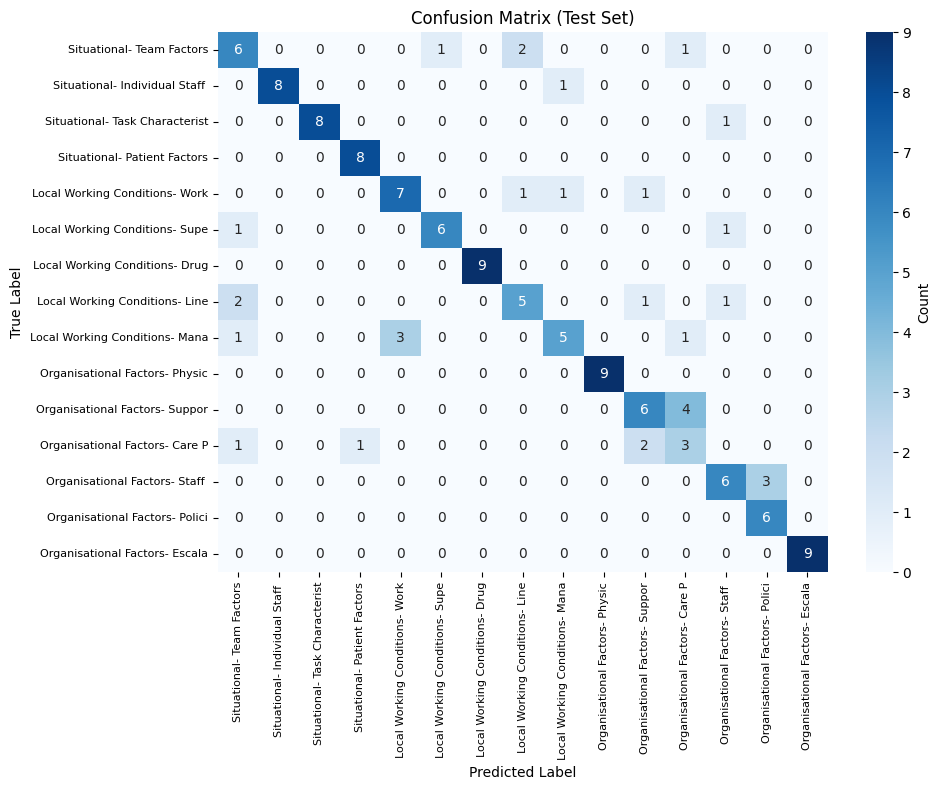

✓ Confusion matrix saved as confusion_matrix.png


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique labels that appear in predictions or true labels
unique_labels_in_test = np.unique(np.concatenate([true_labels, predictions]))
labels_for_cm = [all_labels[i] for i in unique_labels_in_test]

# Create confusion matrix only for labels present in test set
cm = confusion_matrix(true_labels, predictions, labels=unique_labels_in_test)

print(f"Confusion matrix dimensions: {cm.shape[0]} x {cm.shape[1]}")
print(f"Labels in test set: {len(unique_labels_in_test)} out of {num_labels} total\n")

# For large number of classes, show top N most frequent
if len(unique_labels_in_test) > 20:
    # Get top 15 most frequent classes in test set
    label_counts = pd.Series(true_labels).value_counts().head(15)
    top_classes_idx = [np.where(unique_labels_in_test == idx)[0][0] for idx in label_counts.index if idx in unique_labels_in_test]
    top_labels = [labels_for_cm[i] for i in top_classes_idx[:15]]

    # Filter confusion matrix
    cm_subset = cm[np.ix_(top_classes_idx, top_classes_idx)]

    print(f"Showing confusion matrix for top 15 most frequent classes\n")
else:
    cm_subset = cm
    top_labels = labels_for_cm

# Plot
plt.figure(figsize=(max(10, len(top_labels)*0.6), max(8, len(top_labels)*0.5)))
sns.heatmap(
    cm_subset,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[label[:30] for label in top_labels],
    yticklabels=[label[:30] for label in top_labels],
    cbar_kws={'label': 'Count'}
)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.title('Confusion Matrix (Test Set)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as confusion_matrix.png")

## 17. Inference Functions

In [33]:
def predict_concept(text: str, return_probabilities: bool = False):
    """
    Predict concept annotation for a single text
    """
    text = clean_text(text)

    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()

    predicted_label = id2label[predicted_class]

    if return_probabilities:
        top5_probs, top5_indices = torch.topk(probs[0], k=min(5, num_labels))
        top5_predictions = [
            (id2label[idx.item()], prob.item())
            for idx, prob in zip(top5_indices, top5_probs)
        ]
        return predicted_label, top5_predictions

    return predicted_label


def predict_batch(texts: List[str], batch_size: int = 32):
    """
    Predict concept annotations for multiple texts
    """
    predictions = []

    for i in range(0, len(texts), batch_size):
        batch = [clean_text(t) for t in texts[i:i+batch_size]]

        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()

        batch_labels = [id2label[pred] for pred in batch_predictions]
        predictions.extend(batch_labels)

    return predictions

print("✓ Inference functions ready")

✓ Inference functions ready


## 18. Test Inference on Sample Sentences

In [34]:
sample_sentences = [
    "Staff were not provided with adequate training on the new protocols.",
    "The hospital experienced severe staffing shortages during the night shift.",
    "Communication between departments was poor and ineffective.",
    "The patient's risk assessment was not documented properly.",
    "Equipment failure caused a significant delay in treatment."
]

print("SAMPLE PREDICTIONS")
print("=" * 80)

for i, sentence in enumerate(sample_sentences, 1):
    predicted_label, top5 = predict_concept(sentence, return_probabilities=True)

    print(f"\n{i}. {sentence}")
    print(f"   Predicted: {predicted_label}")
    print(f"   Confidence: {top5[0][1]*100:.1f}%")
    print("   Top 3:")
    for j, (label, prob) in enumerate(top5[:3], 1):
        print(f"      {j}. {label}: {prob*100:.1f}%")
print("=" * 80)

SAMPLE PREDICTIONS

1. Staff were not provided with adequate training on the new protocols.
   Predicted: Organisational Factors- Staff Training and Education
   Confidence: 66.0%
   Top 3:
      1. Organisational Factors- Staff Training and Education: 66.0%
      2. Organisational Factors- Policies and Procedures: 5.5%
      3. Communication and Culture- Safety Culture: 5.0%

2. The hospital experienced severe staffing shortages during the night shift.
   Predicted: Local Working Conditions- Workload and Staffing Issues
   Confidence: 29.7%
   Top 3:
      1. Local Working Conditions- Workload and Staffing Issues: 29.7%
      2. Organisational Factors- Support from other departments: 16.9%
      3. Local Working Conditions- Management of Staff and Staffing Levels: 10.0%

3. Communication between departments was poor and ineffective.
   Predicted: Organisational Factors- Support from other departments
   Confidence: 12.1%
   Top 3:
      1. Organisational Factors- Support from other de

## 19. Save Results and Model

In [21]:
import json
import shutil

# Save metadata
metadata = {
    'selected_model': selected_model,
    'model_name': MODEL_NAME,
    'num_labels': num_labels,
    'labels_in_test': len(unique_test_labels),
    'all_labels': all_labels,
    'test_labels': test_label_names,
    'label2id': label2id,
    'id2label': {str(k): v for k, v in id2label.items()},
    'test_accuracy': float(test_results['eval_accuracy']),
    'test_f1_weighted': float(test_results['eval_f1_weighted']),
    'test_f1_macro': float(test_results['eval_f1_macro']),
    'original_training_samples': len(train_df),
    'augmented_training_samples': len(train_texts),
    'validation_samples': len(val_texts),
    'test_samples': len(test_df),
    'augmentation_applied': True,
    'class_weights_used': True
}

with open('./best_model/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved")

# Save test predictions
results_df = test_df[['Text', 'Label', 'predicted_label', 'correct']].copy()
results_df.to_csv('test_predictions.csv', index=False)
files.download('test_predictions.csv')
print("✓ Test predictions saved")

# Save performance summary (only labels present in test set)
performance_df_test.to_csv('per_class_performance.csv', index=False)
files.download('per_class_performance.csv')
print("✓ Per-class performance saved (labels in test set only)")

# Save full performance summary (all labels, including those not in test)
performance_df.to_csv('per_class_performance_full.csv', index=False)
files.download('per_class_performance_full.csv')
print("✓ Full per-class performance saved (all training labels)")

# Package model
print("\nPackaging model...")
shutil.make_archive('trained_concept_model', 'zip', './best_model')
files.download('trained_concept_model.zip')
print("✓ Model packaged and ready for download")

✓ Metadata saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Test predictions saved


NameError: name 'performance_df' is not defined

## 20. Summary

### ✅ Training Complete!

**Key Features Used:**
- ✓ Data augmentation for minority classes
- ✓ Class weights for imbalanced data
- ✓ PathologyBERT specialized model
- ✓ Early stopping to prevent overfitting
- ✓ Comprehensive evaluation metrics

**Files Generated:**
1. `trained_concept_model.zip` - Complete trained model
2. `test_predictions.csv` - All test set predictions
3. `per_class_performance.csv` - Per-class metrics
4. `confusion_matrix.png` - Visual confusion matrix

**Performance:**
- Check cells 13-14 for detailed metrics
- Review cell 15 for error patterns
- See cell 16 for confusion matrix

**To Use the Model:**
```python
# Single prediction
label = predict_concept("Your text here")

# With confidence scores
label, top5 = predict_concept("Your text", return_probabilities=True)

# Batch prediction
labels = predict_batch(["Text 1", "Text 2", "Text 3"])
```

### Next Steps:
1. Review per-class performance for weak classes
2. Analyze error patterns in misclassifications
3. Consider collecting more data for poor-performing classes
4. Deploy model for annotation of new reports